In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="128GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Workers: 1
Total threads: 256,Total memory: 119.21 GiB
Status: running,Using processes: False
Comm: inproc://136.172.118.86/2521529/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 119.21 GiB
Comm: inproc://136.172.118.86/2521529/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/43923/status,Memory: 119.21 GiB
Nanny: None,


In [3]:
def fix_time(ds):
    # we need be carefull witht he attributes in the time data array, because of a weird xarray bug: https://github.com/pydata/xarray/issues/3739
        t = ds.time
        time1 = pd.to_datetime(t.values, format='%Y%m%d')
        hours = np.round((t.values % 1) * 24,2)
        minutes = (hours % 1) * 60
        time2 = pd.to_datetime(hours, format='%H')
        time3 = pd.to_datetime(minutes, format='%M')
        return xr.DataArray(
                pd.to_datetime(pd.to_numeric(time3-time3[0]) + pd.to_numeric(time2-time2[0]) + pd.to_numeric(time1)),
                dims=t.dims,attrs={k:v for k,v in t.attrs.items() if k != "units" and k != "calendar"})



In [4]:
def mask_coord(dset):
        filegr = '/work/mh0287/m300083/experiments/dpp0066/bc_land_frac.nc'
        gridset = xr.open_dataset(filegr,chunks='auto').rename({'cell':'ncells'})
        land_sea_mask = gridset.notsea.persist()
        mask = land_sea_mask.values
        clat = gridset.clat.values*180/np.pi
        clon = gridset.clon.values*180/np.pi
        dset = dset.assign_coords(clon=("ncells",clon),clat=("ncells",clat))
        dset = dset.assign_coords(land_sea_mask=("ncells",mask))
        return dset

In [5]:
def calculate_temporal(data,lat,lon,mask=None):
    if mask is not None:
        dsel = data.where(((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1])) & (data.land_sea_mask==mask),drop=True).mean('time')
    else:
        dsel = data.where(((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1])),drop=True).mean('time')
    return dsel


In [6]:
def temporal_mean(files,var,time,lat,lon,level,mask=None,better_time=True):
    ### mask = 0 to select ocean
    ### mask = 1 to select land
    if better_time == True :
        dsetvar = xr.open_mfdataset(files, engine='netcdf4',combine='by_coords',chunks='auto')[var].sel(height=level)
        variable = dsetvar.assign_coords(time=fix_time(dsetvar)).sel(time=slice(time[0],time[1])).chunk({'height':1,'time':96})
    else:
        dsetvar = xr.open_mfdataset(files, engine='netcdf4',combine='by_coords',chunks='auto')[var]\
        .sel(height=level).sel(time=slice(time[0],time[1]))
        variable = dsetvar.chunk({'time':168}).resample(time='1D').mean('time')
    ####area
    variable = mask_coord(variable)
    ###calculate
    cal_mean = calculate_temporal(variable,lat,lon,mask)
    ###dask
    jobs = dask.persist(cal_mean)
    progress(jobs, notebook=False)
    var_final = dask.compute(cal_mean)
    return var_final[0]

In [17]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_3d_2'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/bm1235/k203123/experiments/ngc2001/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files01 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*')])[:]

In [18]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_3d_2'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/bm1235/k203123/experiments/ngc2002/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files02 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*')])[:]

In [19]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_3d_2'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/bm1235/k203123/experiments/ngc2004/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files04 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*')])[:]

In [20]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_3d_2'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0287/m300083/experiments/dpp0066/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files66 = sorted([str(f) for f in data_path1.glob(f'*{glob_pattern_3d1}*')])[:]

In [21]:
var='va';
lat=[-20,20]
lon=[-80,20]
time = ['2020-03-01','2020-03-31']
lname = 'height'
level = [90]

In [15]:
ua01_mar = temporal_mean(files01,var,time,lat,lon,level,mask=None,better_time=False)

In [22]:
ua02_mar = temporal_mean(files02,var,time,lat,lon,level,mask=None,better_time=False)

In [23]:
ua04_mar = temporal_mean(files04,var,time,lat,lon,level,mask=None,better_time=False)

In [ ]:
ua66_mar = temporal_mean(files66,var,time,lat,lon,level,mask=None,better_time=True)

[#################################       ] | 84% Completed |  4min 59.4s

_Apr_

In [ ]:
time = ['2020-04-01','2020-04-30']

In [26]:
ua01_apr = temporal_mean(files01,var,time,lat,lon,level,mask=None,better_time=False)

[####################################    ] | 91% Completed |  5min  6.4s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
ua02_apr = temporal_mean(files02,var,time,lat,lon,level,mask=None,better_time=False)

[##################################      ] | 87% Completed |  5min  6.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
ua04_apr = temporal_mean(files04,var,time,lat,lon,level,mask=None,better_time=False)

[####################################    ] | 90% Completed |  5min  6.3s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
ua66_apr = temporal_mean(files66,var,time,lat,lon,level,mask=None,better_time=True)

_May_

In [30]:
time = ['2020-05-01','2020-05-31']

In [31]:
ua01_may = temporal_mean(files01,var,time,lat,lon,level,mask=None,better_time=False)

In [32]:
ua02_may = temporal_mean(files02,var,time,lat,lon,level,mask=None,better_time=False)

In [33]:
ua04_may = temporal_mean(files04,var,time,lat,lon,level,mask=None,better_time=False)

In [34]:
ua66_may = temporal_mean(files66,var,time,lat,lon,level,mask=None,better_time=True)

In [21]:
dsetvar = xr.open_mfdataset(files01, engine='netcdf4',combine='by_coords',chunks='auto')['ua'].sel(height=90)

In [23]:
rr = dsetvar.chunk({'time':168})

In [24]:
rr

<xarray.DataArray 'ua' (time: 1161, ncells: 20971520)>
dask.array<rechunk-merge, shape=(1161, 20971520), dtype=float32, chunksize=(168, 2621440), chunktype=numpy.ndarray>
Coordinates:
    height   float64 90.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T03:00:00 ... 2020-06-13
Dimensions without coordinates: ncells
Attributes:
    standard_name:                eastward_wind
    long_name:                    Zonal wind
    units:                        m s-1
    param:                        2.2.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [38]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [43]:
def subplot_scatter(data,inter,ax,lon,lat,ranges,cmaps,extends='both',title='',ax_cbar=None,colorbar=False):
    plot = plt.scatter(data.clon[::inter],data.clat[::inter],s=0.1,c=data[::inter].data,\
               cmap=plt.cm.get_cmap(cmaps, ranges[2]),vmin=ranges[0],vmax=ranges[1],transform=ccrs.PlateCarree())
    if colorbar == True: 
        cb1 = plt.colorbar(plot,extend=extends,orientation='horizontal',cax=ax_cbar,shrink=0.8,pad=0.09)
        cb1.ax.set_xlabel('Zonal wind / m s${-1}$)',fontsize=12)
        cb1.ax.tick_params(labelsize=12)
    ax.set_title(title)   
    ax.coastlines(resolution='110m',linewidth=0.6)
    ax.set_extent([lon[0],lon[1],lat[0],lat[1]], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat[0],lat[1]+0.1,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(np.arange(lon[0], lon[1]+0.1,20),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

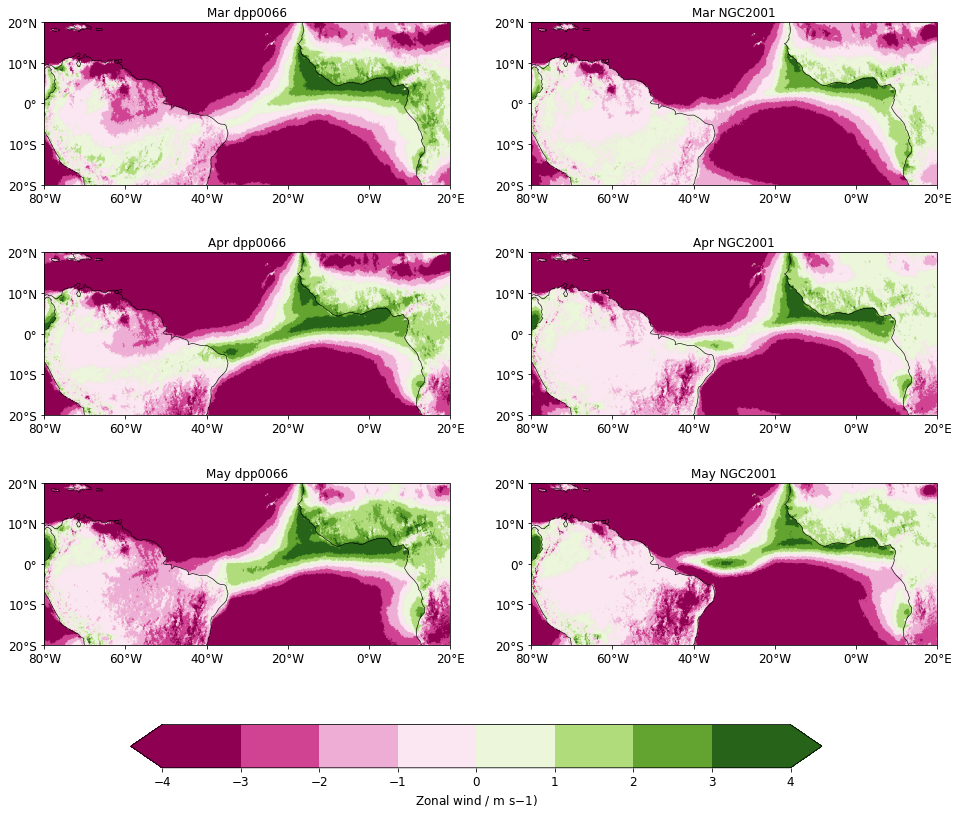

In [48]:
fig = plt.figure(figsize=(16, 12))
ax1=fig.add_axes([0.2,0.0,0.6,0.05])
ax = fig.add_subplot(321,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua66_mar[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Mar dpp0066',\
                ax1,colorbar=True)
ax = fig.add_subplot(323,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua66_apr[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Apr dpp0066',\
                ax1,colorbar=False)
ax = fig.add_subplot(325,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua66_may[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','May dpp0066',\
                ax1,colorbar=False)
ax = fig.add_subplot(322,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua01_mar[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Mar NGC2001',\
                ax1,colorbar=False)
ax = fig.add_subplot(324,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua01_apr[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Apr NGC2001',\
                ax1,colorbar=False)
ax = fig.add_subplot(326,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua01_may[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','May NGC2001',\
                ax1,colorbar=False)

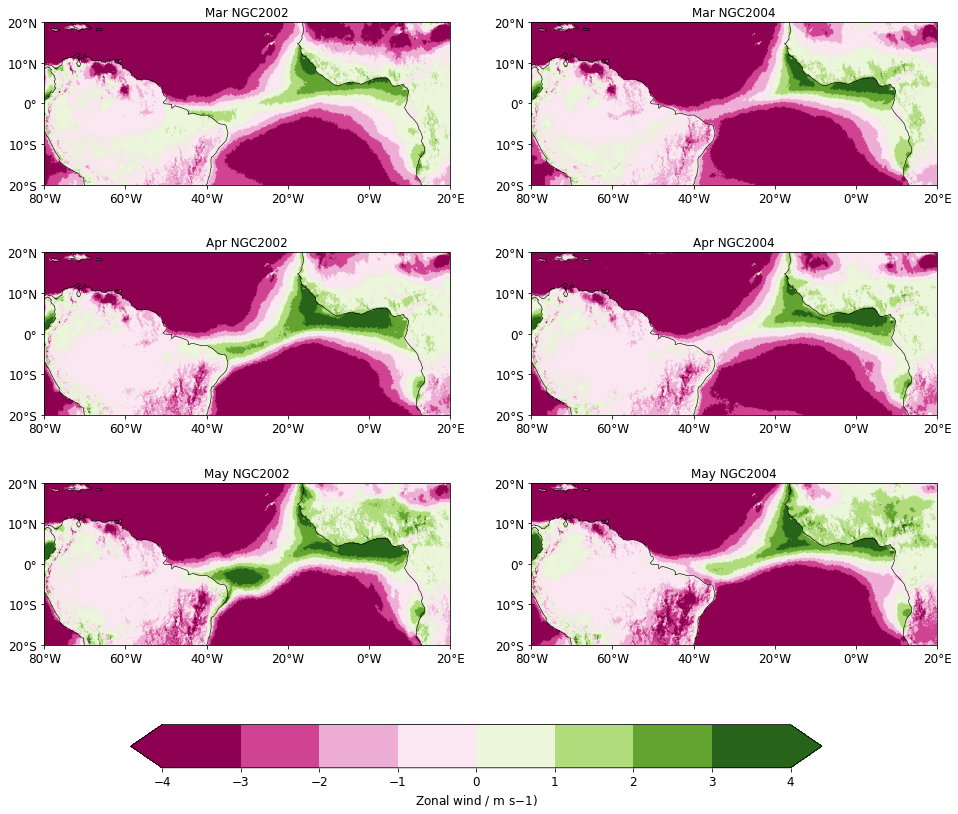

In [50]:
fig = plt.figure(figsize=(16, 12))
ax1=fig.add_axes([0.2,0.0,0.6,0.05])
ax = fig.add_subplot(321,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua02_mar[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Mar NGC2002',\
                ax1,colorbar=True)
ax = fig.add_subplot(323,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua02_apr[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Apr NGC2002',\
                ax1,colorbar=False)
ax = fig.add_subplot(325,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua02_may[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','May NGC2002',\
                ax1,colorbar=False)
ax = fig.add_subplot(322,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua04_mar[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Mar NGC2004',\
                ax1,colorbar=False)
ax = fig.add_subplot(324,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua04_apr[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','Apr NGC2004',\
                ax1,colorbar=False)
ax = fig.add_subplot(326,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter(ua04_may[0,:],int(5),ax,[-80,20],[-20,20],[-4,4,8],'PiYG','both','May NGC2004',\
                ax1,colorbar=False)

Text(0.5, 1.0, 'Precipitation May 2020 - dpp0066')

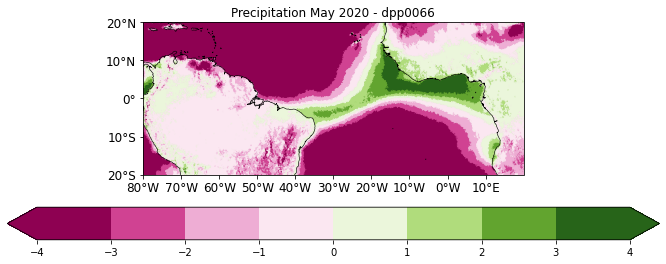

In [37]:
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cs1=plt.scatter(ua02_mar.clon[::5],ua02_mar.clat[::5],s=0.1,c=ua02_apr[0,::5].data,\
               cmap=plt.cm.get_cmap('PiYG', 8),vmin=-4,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.6)
ax.set_extent([-80,20 ,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-80,20,10),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
plt.colorbar(cs1,extend='both',orientation='horizontal')
ax.set_title('Precipitation May 2020 - dpp0066')

Text(0.5, 1.0, 'Precipitation May 2020 - dpp0066')

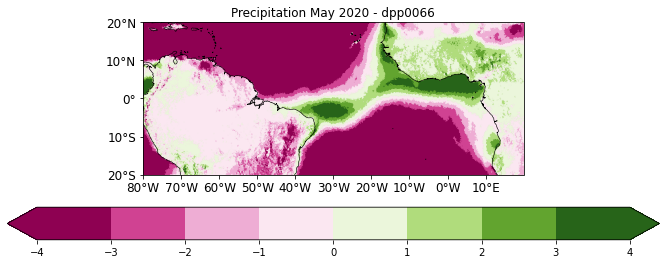

In [39]:
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cs1=plt.scatter(ua02_apr.clon[::5],ua02_mar.clat[::5],s=0.1,c=ua02_may[0,::5].data,\
               cmap=plt.cm.get_cmap('PiYG', 8),vmin=-4,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.6)
ax.set_extent([-80,20 ,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-80,20,10),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
plt.colorbar(cs1,extend='both',orientation='horizontal')
ax.set_title('Precipitation May 2020 - dpp0066')

Text(0.5, 1.0, 'Precipitation May 2020 - dpp0066')

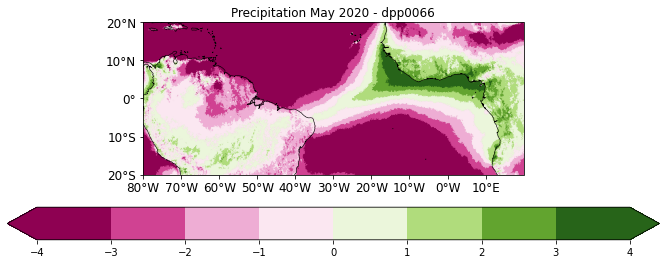

In [42]:
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cs1=plt.scatter(ua02_mar.clon[::5],ua02_mar.clat[::5],s=0.1,c=ua66_mar[0,::5].data,\
               cmap=plt.cm.get_cmap('PiYG', 8),vmin=-4,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.6)
ax.set_extent([-80,20 ,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-80,20,10),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
plt.colorbar(cs1,extend='both',orientation='horizontal')
ax.set_title('Precipitation May 2020 - dpp0066')

Text(0.5, 1.0, 'Precipitation May 2020 - dpp0066')

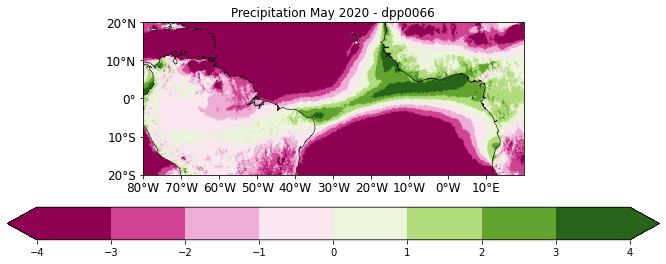

In [40]:
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cs1=plt.scatter(ua02_mar.clon[::5],ua02_mar.clat[::5],s=0.1,c=ua66_apr[0,::5].data,\
               cmap=plt.cm.get_cmap('PiYG', 8),vmin=-4,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.6)
ax.set_extent([-80,20 ,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-80,20,10),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
plt.colorbar(cs1,extend='both',orientation='horizontal')
ax.set_title('Precipitation May 2020 - dpp0066')

Text(0.5, 1.0, 'Precipitation May 2020 - dpp0066')

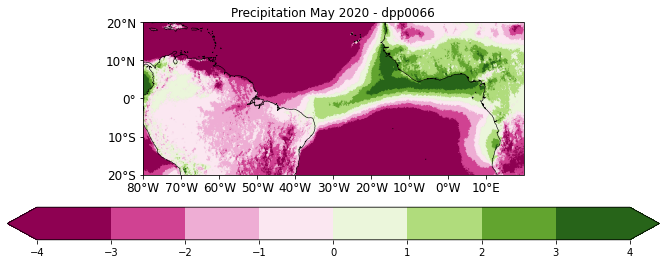

In [41]:
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cs1=plt.scatter(ua02_mar.clon[::5],ua02_mar.clat[::5],s=0.1,c=ua66_may[0,::5].data,\
               cmap=plt.cm.get_cmap('PiYG', 8),vmin=-4,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.6)
ax.set_extent([-80,20 ,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-80,20,10),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
plt.colorbar(cs1,extend='both',orientation='horizontal')
ax.set_title('Precipitation May 2020 - dpp0066')